In [1]:
from skimage.io import imread
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import cv2

import os
import glob
from tqdm import tqdm

from util import load_positive_samples, load_negative_samples

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

%load_ext autoreload
%autoreload 2

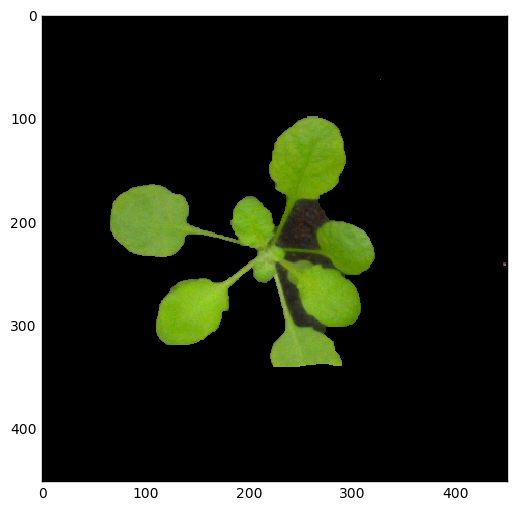

In [3]:
current_path = os.getcwd()
img_path = os.path.join(current_path, 'Datasets', 'Stacks', 'Ara2013-Canon', 'stack_08', 'ara2013_plant08_frame17_rgb.png')

img = imread(img_path)

mask = np.zeros(img.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (50,50,450,290)
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]

plt.imshow(img)
plt.show()

In [2]:
from squeezenet import SqueezeNet, ConvNet
model, callback_list = ConvNet(nb_classes=2, is_testing=True)

Using TensorFlow backend.


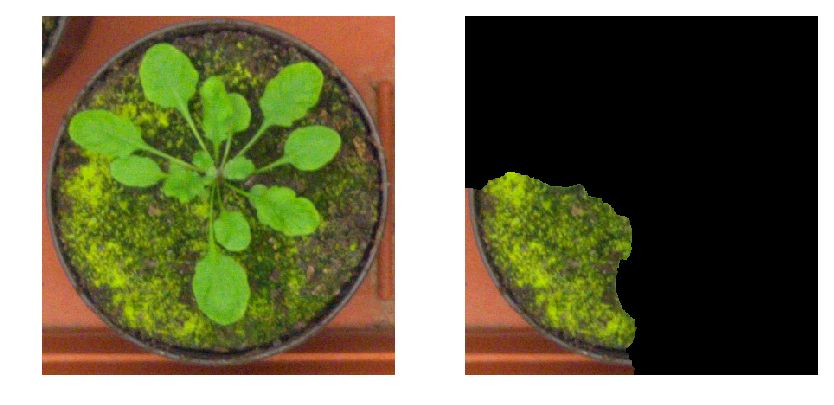

In [4]:
from util import nms
from util import sliding_window

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x[0]) / np.sum(np.exp(x))

min_window_size = (224, 224)
step_size = (30, 30)
confidence_threshold = 0.75
threshold = 0.1

detections = []

current_path = os.getcwd()
img_path = os.path.join(current_path, 'Datasets', 'Stacks', 'Ara2012', 'stack_02', 'ara2012_plant02_frame12_rgb.png')
im = imread(img_path)

candidate_imgs = []
coordinates = []
for (x, y, im_window) in sliding_window(im, min_window_size, step_size):
        if im_window.shape[0] != min_window_size[0] or im_window.shape[1] != min_window_size[1]:
            continue
        candidate_imgs.append(np.transpose(im_window))
        coordinates.append([x, y])

candidate_imgs = np.array(candidate_imgs)
pred = model.predict(candidate_imgs)

for i, score in enumerate(pred):
    confidence = softmax(score)
    if confidence > confidence_threshold:
        detections.append((coordinates[i][0], coordinates[i][1], confidence,
            int(min_window_size[0]),
            int(min_window_size[1])))

# Display the results before performing NMS
clone = im.copy()

# Perform Non Maxima Suppression
left_detections = nms(detections, threshold)

fix, ax = plt.subplots(1, 2)
ax[0].imshow(clone)
ax[0].axis('off')

# Display the results after performing NMS
for (x_tl, y_tl, _, w, h) in left_detections:
    # Draw the detections
    rect = (x_tl, y_tl, x_tl+w, y_tl+h)
    draw_rect = patches.Rectangle((x_tl, y_tl), w, h, linewidth=1,edgecolor='r', facecolor='none')
    ax[0].add_patch(draw_rect)


mask = np.zeros(clone.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

cv2.grabCut(clone,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
clone = clone*mask2[:,:,np.newaxis]

# Create figure and axes
# fig, ax = plt.subplots(1, 2, 2)

# Display the image
ax[1].imshow(clone)
ax[1].axis('off')
plt.show()